In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm.rich import tqdm
import warnings
warnings.filterwarnings("ignore")
 

# Đọc dữ liệu

## Movies

In [2]:
movies_df = pd.read_csv("/kaggle/input/movielens-1m-dataset/movies.dat", 
                        header = None, 
                        sep='::', 
                        names=['MovieID', 'Title', 'Genre'],
                        engine='python',
                        encoding='latin-1')
movies_df.head()

,MovieID,Title,Genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
movies_df['Year'] = movies_df['Title'].apply(lambda x: int(x[-5: -1]))
movies_df['Name'] = movies_df['Title'].apply(lambda x: x[: -7])
movies_df.drop(columns=['Title'], inplace=True)
movies_df.head()

,MovieID,Genre,Year,Name
0,1,Animation|Children's|Comedy,1995,Toy Story
1,2,Adventure|Children's|Fantasy,1995,Jumanji
2,3,Comedy|Romance,1995,Grumpier Old Men
3,4,Comedy|Drama,1995,Waiting to Exhale
4,5,Comedy,1995,Father of the Bride Part II


In [4]:
genres_raw  = movies_df['Genre'].str.split('|', expand=True)
genres_raw.head()

,0,1,2,3,4,5
0,Animation,Children's,Comedy,None,None,None
1,Adventure,Children's,Fantasy,None,None,None
2,Comedy,Romance,None,None,None,None
3,Comedy,Drama,None,None,None,None
4,Comedy,None,None,None,None,None


In [5]:
list_genres = []
for i in range(6):
    list_genres += genres_raw[i].tolist()
set_genres = set(list_genres)
set_genres.remove(None)
set_genres

{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [6]:
for genre in set_genres:
    movies_df[genre] = movies_df['Genre'].apply(lambda x: 1 if genre in x else 0)
movies_df.drop(columns=['Genre'], inplace=True)
movies_df.head()

,MovieID,Year,Name,Children's,Adventure,Horror,Western,Sci-Fi,Drama,Crime,...,Romance,War,Film-Noir,Action,Animation,Comedy,Documentary,Thriller,Musical,Mystery
0,1,1995,Toy Story,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
1,2,1995,Jumanji,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1995,Grumpier Old Men,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,4,1995,Waiting to Exhale,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,1995,Father of the Bride Part II,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Rating

In [7]:
ratings_df = pd.read_csv("/kaggle/input/movielens-1m-dataset/ratings.dat", 
                        header = None, 
                        sep='::', 
                        names=['UserID', 'MovieID', 'Rating', 'Timestamp'],
                        engine='python',
                        encoding='latin-1')
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## Users

In [8]:
users_df = pd.read_csv("/kaggle/input/movielens-1m-dataset/users.dat", 
                       sep='::', 
                       header=None, 
                       names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], 
                       engine='python', 
                       encoding='latin-1')
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Nối các bảng lại

In [9]:
colab_df = pd.merge(ratings_df, users_df, on='UserID', how='inner')
colab_df

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,1193,5,978300760,F,1,10,48067
1,1,661,3,978302109,F,1,10,48067
2,1,914,3,978301968,F,1,10,48067
3,1,3408,4,978300275,F,1,10,48067
4,1,2355,5,978824291,F,1,10,48067
...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,M,25,6,11106
1000205,6040,1094,5,956704887,M,25,6,11106
1000206,6040,562,5,956704746,M,25,6,11106
1000207,6040,1096,4,956715648,M,25,6,11106


In [10]:
merged_df = pd.merge(colab_df, movies_df, on='MovieID', how='inner')
merged_df 

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Year,Name,...,Romance,War,Film-Noir,Action,Animation,Comedy,Documentary,Thriller,Musical,Mystery
0,1,1193,5,978300760,F,1,10,48067,1975,One Flew Over the Cuckoo's Nest,...,0,0,0,0,0,0,0,0,0,0
1,1,661,3,978302109,F,1,10,48067,1996,James and the Giant Peach,...,0,0,0,0,1,0,0,0,1,0
2,1,914,3,978301968,F,1,10,48067,1964,My Fair Lady,...,1,0,0,0,0,0,0,0,1,0
3,1,3408,4,978300275,F,1,10,48067,2000,Erin Brockovich,...,0,0,0,0,0,0,0,0,0,0
4,1,2355,5,978824291,F,1,10,48067,1998,"Bug's Life, A",...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,M,25,6,11106,1989,Weekend at Bernie's,...,0,0,0,0,0,1,0,0,0,0
1000205,6040,1094,5,956704887,M,25,6,11106,1992,"Crying Game, The",...,1,1,0,0,0,0,0,0,0,0
1000206,6040,562,5,956704746,M,25,6,11106,1995,Welcome to the Dollhouse,...,0,0,0,0,0,1,0,0,0,0
1000207,6040,1096,4,956715648,M,25,6,11106,1982,Sophie's Choice,...,0,0,0,0,0,0,0,0,0,0


# Xây dựng mô hình

## Tạo data cho torch

In [11]:
class MovieLensDataset(Dataset):
    def __init__(self, df, embedding=False):        
        self.embedding = embedding
        self.users = torch.tensor(df['UserID'].values - 1, dtype=torch.long) 
        self.movies = torch.tensor(df['MovieID'].values - 1, dtype=torch.long)
        self.ratings = torch.tensor(df['Rating'].values, dtype=torch.float32)
        self.ratings = self.normalize(self.ratings)
        # self.users = torch.full((len(df),), 1, dtype=torch.int32)
        # self.movies = torch.full((len(df),), 1, dtype=torch.int32)
        if not embedding:
            self.users = self.normalize(self.users)
            self.movies = self.normalize(self.movies)
            

    def normalize(self, x):
        """ Chuẩn hóa theo công thức x_norm = (x - mean) / (max - min) """
        return (x.float() - x.float().mean()) / (x.float().max() - x.float().min() + 1e-8)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]


## Mô hình CollaborativeFiltering

In [12]:
class CollaborativeFiltering(nn.Module):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def __init__(self, num_users, num_movies, embed_size=50, learning_rate=0.01, reg_lambda=0.0001, embedding=False):
        super(CollaborativeFiltering, self).__init__()
        self.embedding = embedding
        self.learning_rate = learning_rate
        self.reg_lambda = reg_lambda  # Hệ số Regularization
        self.train_losses = []
        self.valid_losses = []

        if embedding:
            self.user_embed = nn.Embedding(num_users, embed_size)
            self.movie_embed = nn.Embedding(num_movies, embed_size)
            self.user_bias = nn.Embedding(num_users, 1)
            self.movie_bias = nn.Embedding(num_movies, 1)
        else:
            self.linear = nn.Linear(2, 1)  # Đầu vào: user + movie

    def forward(self, user, movie):
        if self.embedding:
            user_vec = self.user_embed(user)
            movie_vec = self.movie_embed(movie)
            dot_product = (user_vec * movie_vec).sum(1, keepdim=True)
            bias = self.user_bias(user) + self.movie_bias(movie)
            return dot_product + bias
        else:
            user = user.float().unsqueeze(1)
            movie = movie.float().unsqueeze(1)
            return self.linear(torch.cat((user, movie), dim=1))

    def compute_loss(self, prediction, rating, regularization=False):
        """ Hàm tính Loss (MSE + Regularization) """
        loss_fn = nn.MSELoss()
        mse_loss = loss_fn(prediction, rating)

        if regularization:
            l2_reg = sum(torch.norm(param, p=2) for param in self.parameters())
            loss = mse_loss + self.reg_lambda * l2_reg
        else:
            loss = mse_loss

        return loss

    def update_weights(self):
        """ Cập nhật trọng số bằng thuật toán tự viết """
        with torch.no_grad():
            for param in self.parameters():
                if param.grad is not None:
                    param -= self.learning_rate * param.grad

    def stochastic_train(self, train_loader, valid_loader, epochs=10, device=device, regularization=False):
        """ Huấn luyện bằng Stochastic Gradient Descent (SGD) - từng mẫu một """
        self.to(device)
        self.train_losses, self.valid_losses = [], []

        for epoch in range(epochs):
            self.train()
            epoch_loss = 0
            # tqdm_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

            for user, movie, rating in train_loader:
                user, movie, rating = user.to(device), movie.to(device), rating.to(device)

                self.zero_grad()
                prediction = self(user, movie).squeeze()
                loss = self.compute_loss(prediction, rating, regularization)
                loss.backward()

                self.update_weights()
                epoch_loss += loss.item()

                # tqdm_loader.set_postfix(Current_Train_Loss=loss.item())

            self.train_losses.append(epoch_loss / len(train_loader))
            valid_loss = self.evaluate(valid_loader, device)
            self.valid_losses.append(valid_loss)

            print(f"Epoch {epoch+1}/{epochs} Train Loss: {self.train_losses[-1]:.4f}, Test Loss: {self.valid_losses[-1]:.4f}")

    def mini_batch_train(self, train_loader, valid_loader, batch_size=32, epochs=10, device=device, regularization=False):
        """ Huấn luyện bằng Mini-Batch Gradient Descent (MBGD) """
        self.to(device)
        self.train_losses, self.valid_losses = [], []

        for epoch in range(epochs):
            self.train()
            epoch_loss = 0
            num_batches = 0
            # tqdm_loader = tqdm(train_loader, desc=f"Mini-Batch GD - Epoch {epoch+1}/{epochs}")

            for batch_idx, (user, movie, rating) in enumerate(train_loader):
                user, movie, rating = user.to(device), movie.to(device), rating.to(device)

                self.zero_grad()
                prediction = self(user, movie).squeeze()
                loss = self.compute_loss(prediction, rating, regularization)
                loss.backward()

                if (batch_idx + 1) % batch_size == 0:
                    self.update_weights()

                epoch_loss += loss.item()
                num_batches += 1

                # tqdm_loader.set_postfix(Current_Train_Loss=loss.item())

            self.train_losses.append(epoch_loss / num_batches)
            valid_loss = self.evaluate(valid_loader, device)
            self.valid_losses.append(valid_loss)

            print(f"Epoch {epoch+1}/{epochs} Train Loss: {self.train_losses[-1]:.4f}, Test Loss: {self.valid_losses[-1]:.4f}")

    def batch_train(self, train_loader, valid_loader, epochs=10, device=device, regularization=False):
        """ Huấn luyện bằng Batch Gradient Descent (BGD) """
        self.to(device)
        self.train_losses, self.valid_losses = [], []

        for epoch in range(epochs):
            self.train()
            all_users, all_movies, all_ratings = [], [], []
            # tqdm_loader = tqdm(train_loader, desc=f"Batch GD - Epoch {epoch+1}/{epochs}")

            for user, movie, rating in train_loader:
                all_users.append(user)
                all_movies.append(movie)
                all_ratings.append(rating)

            all_users = torch.cat(all_users).to(device)
            all_movies = torch.cat(all_movies).to(device)
            all_ratings = torch.cat(all_ratings).to(device)

            self.zero_grad()
            prediction = self(all_users, all_movies).squeeze()
            loss = self.compute_loss(prediction, all_ratings, regularization)
            loss.backward()

            self.update_weights()
            self.train_losses.append(loss.item())
            valid_loss = self.evaluate(valid_loader, device)
            self.valid_losses.append(valid_loss)

            # tqdm_loader.set_postfix(Current_Train_Loss=loss.item())

            print(f"Epoch {epoch+1}/{epochs} Train Loss: {self.train_losses[-1]:.4f}, Test Loss: {self.valid_losses[-1]:.4f}")

            
    def evaluate(self, test_loader, device=device):
        """ Đánh giá mô hình bằng MSE """
        self.eval()
        loss_fn = nn.MSELoss()
        total_loss = 0

        with torch.no_grad():
            for user, movie, rating in test_loader:
                user, movie, rating = user.to(device), movie.to(device), rating.to(device)
                prediction = self(user, movie).squeeze()
                loss = loss_fn(prediction, rating)
                total_loss += loss.item()

        return total_loss / len(test_loader)

    def plot_results(self, test_loader, device=device):
        """ Vẽ biểu đồ Train Loss, Validation RMSE và Dự đoán so với thực tế """
        epochs = range(1, len(self.train_losses) + 1)

        # Biểu đồ Loss
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label="Train Loss", color='Red', alpha=0.6)
        plt.plot(epochs, self.valid_losses, label="Validation RMSE", color='Blue', alpha=0.6)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Train Loss per Epoch")
        plt.legend()

        real_values, predicted_values = [], []
        with torch.no_grad():
            for user, movie, rating in test_loader:
                user, movie, rating = user.to(device), movie.to(device), rating.to(device)
                prediction = self(user, movie).squeeze()
                real_values.extend(rating.cpu().numpy())
                predicted_values.extend(prediction.cpu().numpy())

        plt.subplot(1, 2, 2)
        plt.scatter(real_values, predicted_values, alpha=0.1, color='Green')
        plt.xlabel("Actual Ratings")
        plt.ylabel("Predicted Ratings")
        plt.title("Actual vs Predicted Ratings") 

        plt.tight_layout()
        plt.show()

In [13]:
num_users = ratings_df['UserID'].max() 
num_movies = ratings_df['MovieID'].max()

print(f"Users: {num_users}, Movies: {num_movies}")

Users: 6040, Movies: 3952


In [14]:
# Chia tập dữ liệu thành Train/Test
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)
train_dataset = MovieLensDataset(train_df)
test_dataset = MovieLensDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# SGD

## Không có $\lambda$

Epoch 1/10 Train Loss: 0.0938, Test Loss: 0.0843
Epoch 2/10 Train Loss: 0.0808, Test Loss: 0.0795
Epoch 3/10 Train Loss: 0.0783, Test Loss: 0.0784
Epoch 4/10 Train Loss: 0.0777, Test Loss: 0.0781
Epoch 5/10 Train Loss: 0.0776, Test Loss: 0.0781
Epoch 6/10 Train Loss: 0.0776, Test Loss: 0.0781
Epoch 7/10 Train Loss: 0.0776, Test Loss: 0.0781
Epoch 8/10 Train Loss: 0.0776, Test Loss: 0.0781
Epoch 9/10 Train Loss: 0.0776, Test Loss: 0.0781
Epoch 10/10 Train Loss: 0.0776, Test Loss: 0.0781


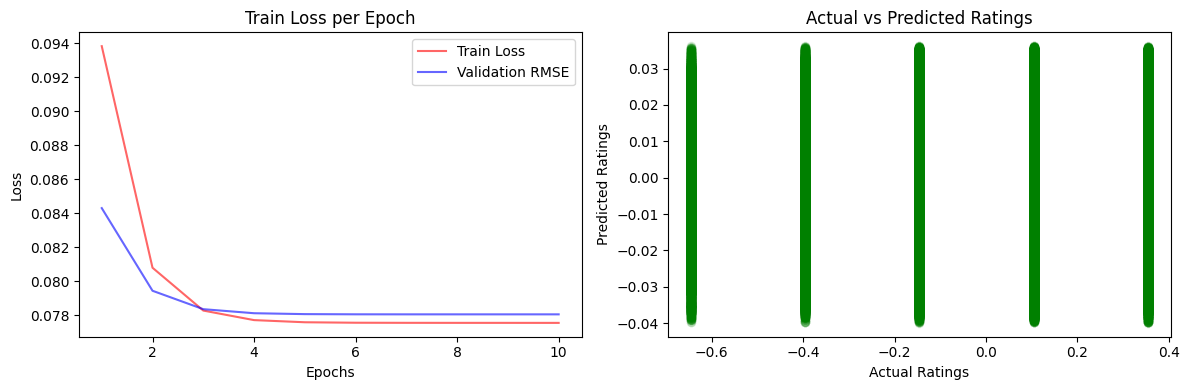

In [15]:
model_sgd = CollaborativeFiltering(
    num_users, num_movies, learning_rate=3e-3
)

model_sgd.stochastic_train(train_loader, test_loader , epochs=10, regularization=False)
model_sgd.plot_results(test_loader)

## Có $\lambda$

Epoch 1/10 Train Loss: 0.1010, Test Loss: 0.0814
Epoch 2/10 Train Loss: 0.0794, Test Loss: 0.0788
Epoch 3/10 Train Loss: 0.0780, Test Loss: 0.0782
Epoch 4/10 Train Loss: 0.0777, Test Loss: 0.0781
Epoch 5/10 Train Loss: 0.0776, Test Loss: 0.0781
Epoch 6/10 Train Loss: 0.0776, Test Loss: 0.0781
Epoch 7/10 Train Loss: 0.0776, Test Loss: 0.0781
Epoch 8/10 Train Loss: 0.0776, Test Loss: 0.0781
Epoch 9/10 Train Loss: 0.0776, Test Loss: 0.0781
Epoch 10/10 Train Loss: 0.0776, Test Loss: 0.0781


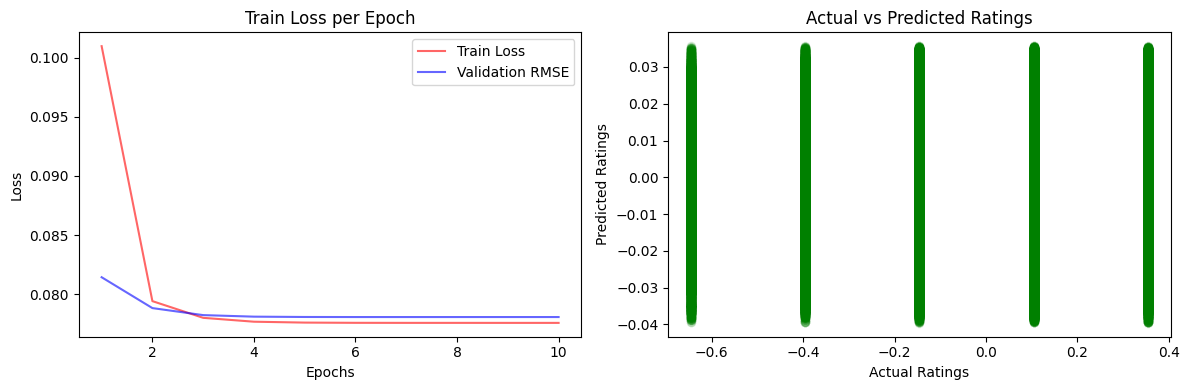

In [16]:
model_sgd_reg = CollaborativeFiltering(
    num_users, num_movies, learning_rate=3e-3
)

model_sgd_reg.stochastic_train(train_loader, test_loader , epochs=10, regularization=True)
model_sgd_reg.plot_results(test_loader)

# Batch GD

## Không có $\lambda$

Epoch 1/50 Train Loss: 0.3432, Test Loss: 0.2652
Epoch 2/50 Train Loss: 0.2651, Test Loss: 0.2147
Epoch 3/50 Train Loss: 0.2146, Test Loss: 0.1819
Epoch 4/50 Train Loss: 0.1818, Test Loss: 0.1603
Epoch 5/50 Train Loss: 0.1602, Test Loss: 0.1461
Epoch 6/50 Train Loss: 0.1459, Test Loss: 0.1364
Epoch 7/50 Train Loss: 0.1363, Test Loss: 0.1298
Epoch 8/50 Train Loss: 0.1297, Test Loss: 0.1251
Epoch 9/50 Train Loss: 0.1250, Test Loss: 0.1217
Epoch 10/50 Train Loss: 0.1215, Test Loss: 0.1190
Epoch 11/50 Train Loss: 0.1189, Test Loss: 0.1169
Epoch 12/50 Train Loss: 0.1168, Test Loss: 0.1152
Epoch 13/50 Train Loss: 0.1150, Test Loss: 0.1137
Epoch 14/50 Train Loss: 0.1135, Test Loss: 0.1123
Epoch 15/50 Train Loss: 0.1122, Test Loss: 0.1111
Epoch 16/50 Train Loss: 0.1110, Test Loss: 0.1100
Epoch 17/50 Train Loss: 0.1098, Test Loss: 0.1089
Epoch 18/50 Train Loss: 0.1088, Test Loss: 0.1079
Epoch 19/50 Train Loss: 0.1078, Test Loss: 0.1070
Epoch 20/50 Train Loss: 0.1068, Test Loss: 0.1060
Epoch 21/

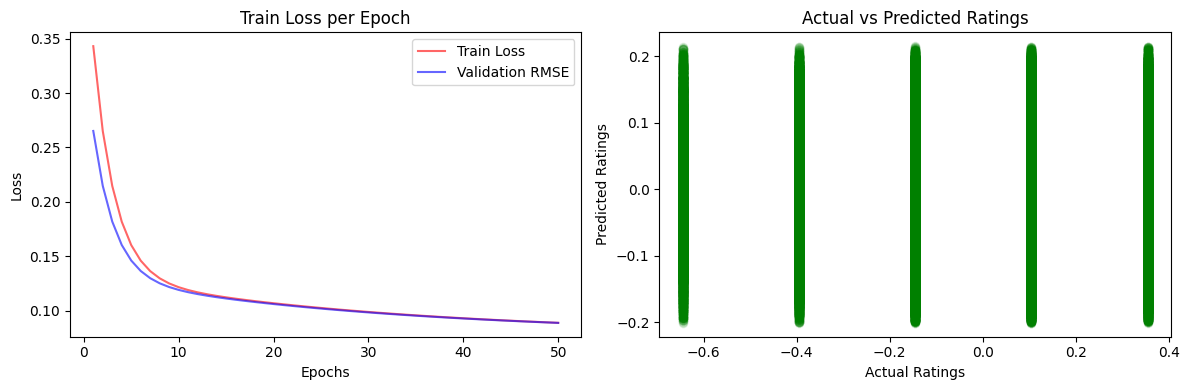

In [17]:
model_bgd = CollaborativeFiltering(
    num_users, num_movies, learning_rate=0.1
)

model_bgd.batch_train(train_loader, test_loader , epochs=50, regularization=True)
model_bgd.plot_results(test_loader)

## Có $\lambda$

Epoch 1/50 Train Loss: 0.2550, Test Loss: 0.2096
Epoch 2/50 Train Loss: 0.2087, Test Loss: 0.1794
Epoch 3/50 Train Loss: 0.1786, Test Loss: 0.1596
Epoch 4/50 Train Loss: 0.1588, Test Loss: 0.1464
Epoch 5/50 Train Loss: 0.1456, Test Loss: 0.1375
Epoch 6/50 Train Loss: 0.1366, Test Loss: 0.1313
Epoch 7/50 Train Loss: 0.1304, Test Loss: 0.1268
Epoch 8/50 Train Loss: 0.1260, Test Loss: 0.1235
Epoch 9/50 Train Loss: 0.1227, Test Loss: 0.1210
Epoch 10/50 Train Loss: 0.1202, Test Loss: 0.1189
Epoch 11/50 Train Loss: 0.1181, Test Loss: 0.1172
Epoch 12/50 Train Loss: 0.1164, Test Loss: 0.1157
Epoch 13/50 Train Loss: 0.1149, Test Loss: 0.1143
Epoch 14/50 Train Loss: 0.1135, Test Loss: 0.1131
Epoch 15/50 Train Loss: 0.1123, Test Loss: 0.1119
Epoch 16/50 Train Loss: 0.1112, Test Loss: 0.1108
Epoch 17/50 Train Loss: 0.1101, Test Loss: 0.1098
Epoch 18/50 Train Loss: 0.1090, Test Loss: 0.1088
Epoch 19/50 Train Loss: 0.1080, Test Loss: 0.1079
Epoch 20/50 Train Loss: 0.1071, Test Loss: 0.1069
Epoch 21/

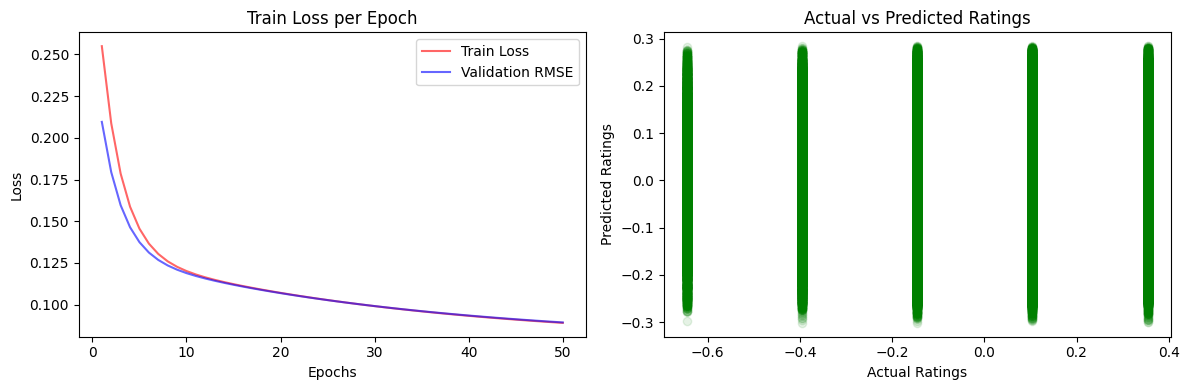

In [18]:
model_bgd_reg = CollaborativeFiltering(
    num_users, num_movies, learning_rate=0.1
)

model_bgd_reg.batch_train(train_loader, test_loader , epochs=50, regularization=True)
model_bgd_reg.plot_results(test_loader)

# Mini-batch GD

## Không có $\lambda$

Epoch 1/50 Train Loss: 0.2310, Test Loss: 0.1469
Epoch 2/50 Train Loss: 0.1228, Test Loss: 0.1088
Epoch 3/50 Train Loss: 0.1036, Test Loss: 0.1004
Epoch 4/50 Train Loss: 0.0981, Test Loss: 0.0966
Epoch 5/50 Train Loss: 0.0949, Test Loss: 0.0938
Epoch 6/50 Train Loss: 0.0923, Test Loss: 0.0914
Epoch 7/50 Train Loss: 0.0901, Test Loss: 0.0895
Epoch 8/50 Train Loss: 0.0883, Test Loss: 0.0878
Epoch 9/50 Train Loss: 0.0867, Test Loss: 0.0863
Epoch 10/50 Train Loss: 0.0854, Test Loss: 0.0851
Epoch 11/50 Train Loss: 0.0842, Test Loss: 0.0841
Epoch 12/50 Train Loss: 0.0833, Test Loss: 0.0832
Epoch 13/50 Train Loss: 0.0825, Test Loss: 0.0825
Epoch 14/50 Train Loss: 0.0817, Test Loss: 0.0818
Epoch 15/50 Train Loss: 0.0811, Test Loss: 0.0812
Epoch 16/50 Train Loss: 0.0806, Test Loss: 0.0808
Epoch 17/50 Train Loss: 0.0802, Test Loss: 0.0804
Epoch 18/50 Train Loss: 0.0798, Test Loss: 0.0800
Epoch 19/50 Train Loss: 0.0795, Test Loss: 0.0798
Epoch 20/50 Train Loss: 0.0792, Test Loss: 0.0795
Epoch 21/

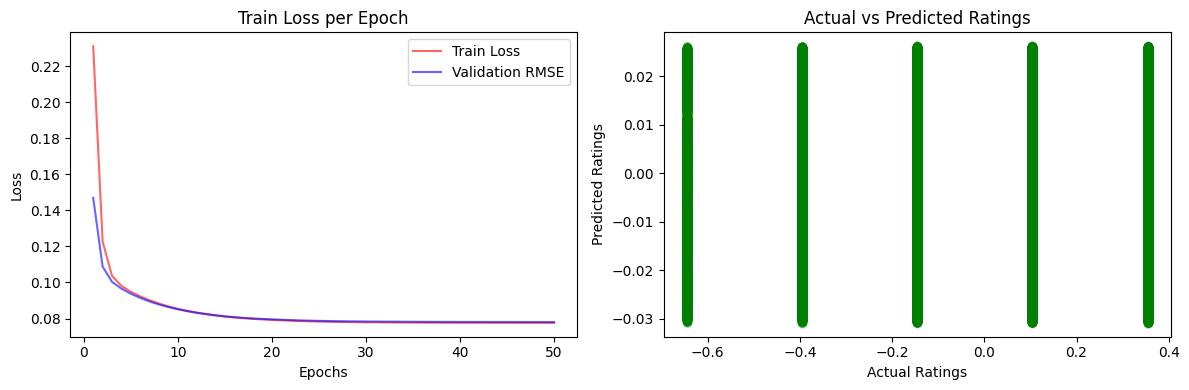

In [19]:
model_mbgd = CollaborativeFiltering(
    num_users, num_movies, learning_rate=1e-2
)

model_mbgd.mini_batch_train(train_loader, test_loader , epochs=50, regularization=True)
model_mbgd.plot_results(test_loader)

## Có $\lambda$

Epoch 1/50 Train Loss: 0.1116, Test Loss: 0.0917
Epoch 2/50 Train Loss: 0.0855, Test Loss: 0.0827
Epoch 3/50 Train Loss: 0.0812, Test Loss: 0.0811
Epoch 4/50 Train Loss: 0.0803, Test Loss: 0.0805
Epoch 5/50 Train Loss: 0.0798, Test Loss: 0.0801
Epoch 6/50 Train Loss: 0.0795, Test Loss: 0.0798
Epoch 7/50 Train Loss: 0.0792, Test Loss: 0.0796
Epoch 8/50 Train Loss: 0.0790, Test Loss: 0.0794
Epoch 9/50 Train Loss: 0.0788, Test Loss: 0.0792
Epoch 10/50 Train Loss: 0.0786, Test Loss: 0.0790
Epoch 11/50 Train Loss: 0.0785, Test Loss: 0.0789
Epoch 12/50 Train Loss: 0.0783, Test Loss: 0.0788
Epoch 13/50 Train Loss: 0.0782, Test Loss: 0.0787
Epoch 14/50 Train Loss: 0.0781, Test Loss: 0.0786
Epoch 15/50 Train Loss: 0.0780, Test Loss: 0.0785
Epoch 16/50 Train Loss: 0.0780, Test Loss: 0.0785
Epoch 17/50 Train Loss: 0.0779, Test Loss: 0.0784
Epoch 18/50 Train Loss: 0.0779, Test Loss: 0.0784
Epoch 19/50 Train Loss: 0.0778, Test Loss: 0.0783
Epoch 20/50 Train Loss: 0.0778, Test Loss: 0.0783
Epoch 21/

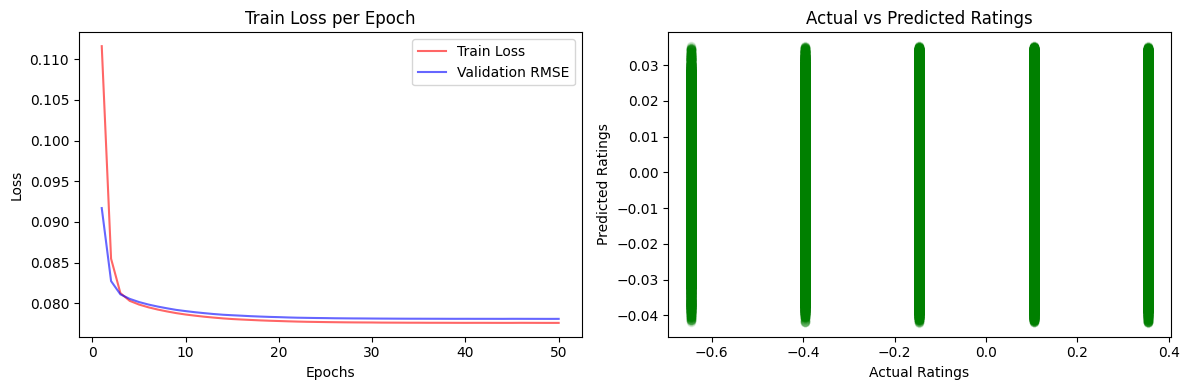

In [20]:
model_mbgd_reg = CollaborativeFiltering(
    num_users, num_movies, learning_rate=1e-2
)

model_mbgd_reg.mini_batch_train(train_loader, test_loader , epochs=50, regularization=True)
model_mbgd_reg.plot_results(test_loader)

# Embedding

In [21]:
# Chia tập dữ liệu thành Train/Test
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)
train_dataset = MovieLensDataset(train_df, embedding = True)
test_dataset = MovieLensDataset(test_df, embedding = True)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

Epoch 1/300 Train Loss: 2.0000, Test Loss: 1.0619
Epoch 2/300 Train Loss: 0.7955, Test Loss: 0.5908
Epoch 3/300 Train Loss: 0.4964, Test Loss: 0.4043
Epoch 4/300 Train Loss: 0.3603, Test Loss: 0.3063
Epoch 5/300 Train Loss: 0.2836, Test Loss: 0.2468
Epoch 6/300 Train Loss: 0.2350, Test Loss: 0.2074
Epoch 7/300 Train Loss: 0.2018, Test Loss: 0.1795
Epoch 8/300 Train Loss: 0.1779, Test Loss: 0.1589
Epoch 9/300 Train Loss: 0.1600, Test Loss: 0.1432
Epoch 10/300 Train Loss: 0.1462, Test Loss: 0.1308
Epoch 11/300 Train Loss: 0.1352, Test Loss: 0.1210
Epoch 12/300 Train Loss: 0.1264, Test Loss: 0.1129
Epoch 13/300 Train Loss: 0.1191, Test Loss: 0.1062
Epoch 14/300 Train Loss: 0.1131, Test Loss: 0.1007
Epoch 15/300 Train Loss: 0.1080, Test Loss: 0.0959
Epoch 16/300 Train Loss: 0.1037, Test Loss: 0.0919
Epoch 17/300 Train Loss: 0.1000, Test Loss: 0.0884
Epoch 18/300 Train Loss: 0.0967, Test Loss: 0.0853
Epoch 19/300 Train Loss: 0.0939, Test Loss: 0.0827
Epoch 20/300 Train Loss: 0.0915, Test Lo

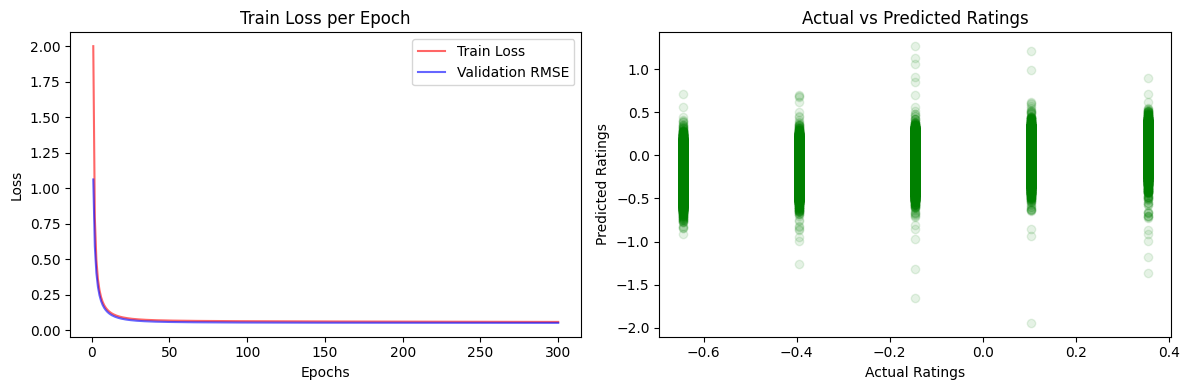

In [22]:
model_sgd_reg_eb = CollaborativeFiltering(
    num_users, num_movies, embed_size=2, learning_rate=0.5, embedding=True
)

model_sgd_reg_eb.stochastic_train(train_loader, test_loader , epochs=300, regularization=True)
model_sgd_reg_eb.plot_results(test_loader)

Epoch 1/300 Train Loss: 4.2326, Test Loss: 2.9007
Epoch 2/300 Train Loss: 2.9255, Test Loss: 2.2548
Epoch 3/300 Train Loss: 2.2716, Test Loss: 1.8513
Epoch 4/300 Train Loss: 1.8639, Test Loss: 1.5716
Epoch 5/300 Train Loss: 1.5818, Test Loss: 1.3654
Epoch 6/300 Train Loss: 1.3739, Test Loss: 1.2067
Epoch 7/300 Train Loss: 1.2141, Test Loss: 1.0809
Epoch 8/300 Train Loss: 1.0873, Test Loss: 0.9785
Epoch 9/300 Train Loss: 0.9843, Test Loss: 0.8937
Epoch 10/300 Train Loss: 0.8989, Test Loss: 0.8222
Epoch 11/300 Train Loss: 0.8271, Test Loss: 0.7612
Epoch 12/300 Train Loss: 0.7657, Test Loss: 0.7085
Epoch 13/300 Train Loss: 0.7128, Test Loss: 0.6625
Epoch 14/300 Train Loss: 0.6666, Test Loss: 0.6220
Epoch 15/300 Train Loss: 0.6260, Test Loss: 0.5861
Epoch 16/300 Train Loss: 0.5900, Test Loss: 0.5541
Epoch 17/300 Train Loss: 0.5579, Test Loss: 0.5253
Epoch 18/300 Train Loss: 0.5291, Test Loss: 0.4993
Epoch 19/300 Train Loss: 0.5032, Test Loss: 0.4757
Epoch 20/300 Train Loss: 0.4796, Test Lo

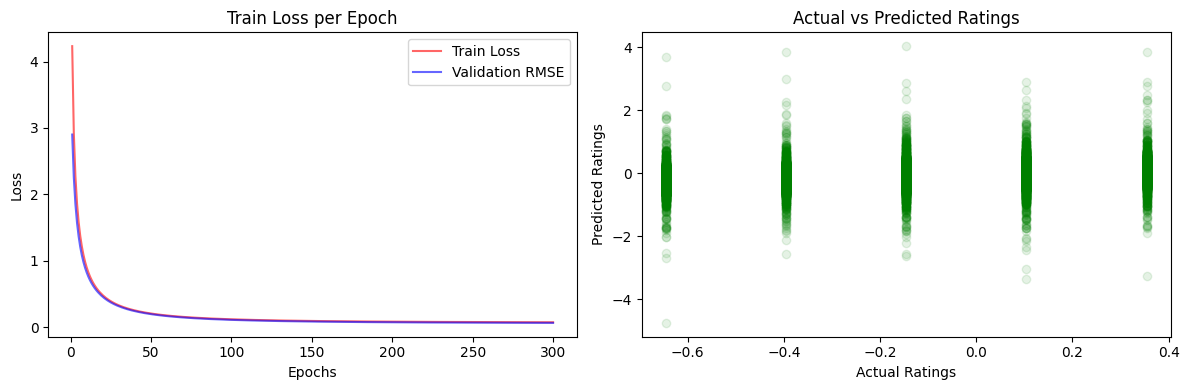

In [23]:
model_bgd_reg_eb = CollaborativeFiltering(
    num_users, num_movies, embed_size=2, learning_rate=100, embedding=True
)

model_bgd_reg_eb.batch_train(train_loader, test_loader , epochs=300, regularization=True)
model_bgd_reg_eb.plot_results(test_loader)

Epoch 1/300 Train Loss: 3.0097, Test Loss: 2.2297
Epoch 2/300 Train Loss: 1.8671, Test Loss: 1.5187
Epoch 3/300 Train Loss: 1.3415, Test Loss: 1.1442
Epoch 4/300 Train Loss: 1.0388, Test Loss: 0.9109
Epoch 5/300 Train Loss: 0.8467, Test Loss: 0.7554
Epoch 6/300 Train Loss: 0.7131, Test Loss: 0.6464
Epoch 7/300 Train Loss: 0.6170, Test Loss: 0.5636
Epoch 8/300 Train Loss: 0.5428, Test Loss: 0.4966
Epoch 9/300 Train Loss: 0.4835, Test Loss: 0.4454
Epoch 10/300 Train Loss: 0.4359, Test Loss: 0.4037
Epoch 11/300 Train Loss: 0.3963, Test Loss: 0.3675
Epoch 12/300 Train Loss: 0.3636, Test Loss: 0.3381
Epoch 13/300 Train Loss: 0.3361, Test Loss: 0.3137
Epoch 14/300 Train Loss: 0.3133, Test Loss: 0.2928
Epoch 15/300 Train Loss: 0.2935, Test Loss: 0.2741
Epoch 16/300 Train Loss: 0.2759, Test Loss: 0.2578
Epoch 17/300 Train Loss: 0.2606, Test Loss: 0.2435
Epoch 18/300 Train Loss: 0.2471, Test Loss: 0.2304
Epoch 19/300 Train Loss: 0.2347, Test Loss: 0.2188
Epoch 20/300 Train Loss: 0.2237, Test Lo

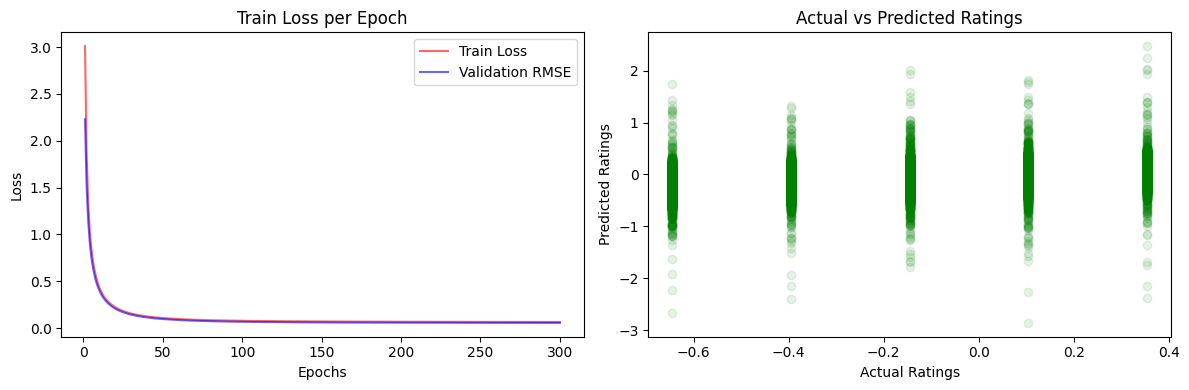

In [24]:
model_mbgd_reg_eb = CollaborativeFiltering(
    num_users, num_movies, embed_size=2, learning_rate=5, embedding=True
)

model_mbgd_reg_eb.mini_batch_train(train_loader, test_loader , epochs=300, regularization=True)
model_mbgd_reg_eb.plot_results(test_loader)

Epoch 1/300 Train Loss: 40.9392, Test Loss: 31.8465
Epoch 2/300 Train Loss: 26.2988, Test Loss: 21.6555
Epoch 3/300 Train Loss: 18.4208, Test Loss: 15.9794
Epoch 4/300 Train Loss: 13.7559, Test Loss: 12.4055
Epoch 5/300 Train Loss: 10.7775, Test Loss: 10.0339
Epoch 6/300 Train Loss: 8.7457, Test Loss: 8.4310
Epoch 7/300 Train Loss: 7.3027, Test Loss: 7.2052
Epoch 8/300 Train Loss: 6.2045, Test Loss: 6.2991
Epoch 9/300 Train Loss: 5.3728, Test Loss: 5.5948
Epoch 10/300 Train Loss: 4.7129, Test Loss: 4.9959
Epoch 11/300 Train Loss: 4.1745, Test Loss: 4.5173
Epoch 12/300 Train Loss: 3.7420, Test Loss: 4.1310
Epoch 13/300 Train Loss: 3.3781, Test Loss: 3.8028
Epoch 14/300 Train Loss: 3.0767, Test Loss: 3.5192
Epoch 15/300 Train Loss: 2.8184, Test Loss: 3.2658
Epoch 16/300 Train Loss: 2.5832, Test Loss: 3.0488
Epoch 17/300 Train Loss: 2.3799, Test Loss: 2.8721
Epoch 18/300 Train Loss: 2.2098, Test Loss: 2.7068
Epoch 19/300 Train Loss: 2.0589, Test Loss: 2.5727
Epoch 20/300 Train Loss: 1.927

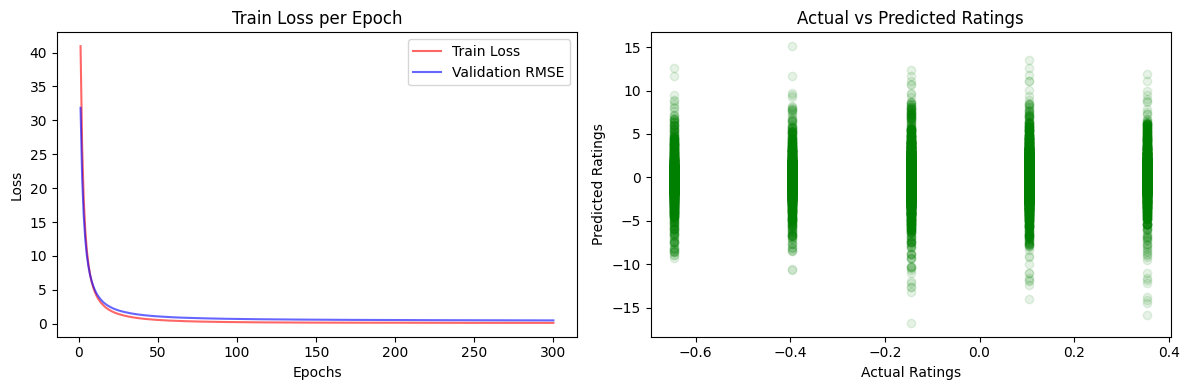

In [25]:
model_mbgd_reg_eb = CollaborativeFiltering(
    num_users, num_movies, embed_size=50, learning_rate=5, embedding = True
)

model_mbgd_reg_eb.mini_batch_train(train_loader, test_loader , epochs=300, regularization=True)
model_mbgd_reg_eb.plot_results(test_loader)